# Mask Detection and Social Distancing  

### Importing Packages

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance
import cv2
import warnings
warnings.filterwarnings('ignore')

### Haar Cascade Classifier

It is an Object Detection Algorithm used to identify faces in an image or a real time video.

In [2]:
face_model = cv2.CascadeClassifier('input/haarcascades/haarcascade_frontalface_default.xml')

Testing the Classifier on a sample image.

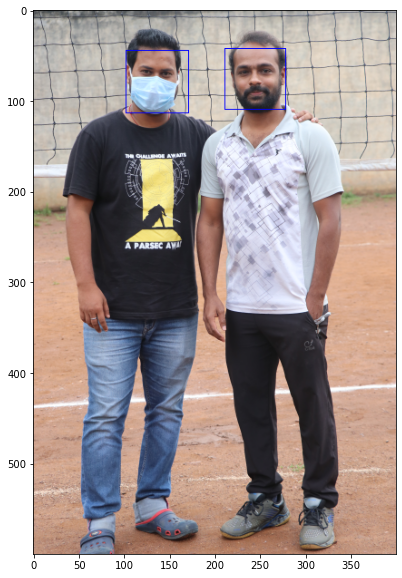

In [3]:
img = cv2.imread('input/IMG_2707.JPG')

scale_percent = 10
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)

img = cv2.resize(img,dim,interpolation = cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=5) #returns a list of (x,y,w,h) tuples
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(10,10))
plt.imshow(out_img)

### Detecting social distancing violations

In [4]:
MIN_DISTANCE = 130 

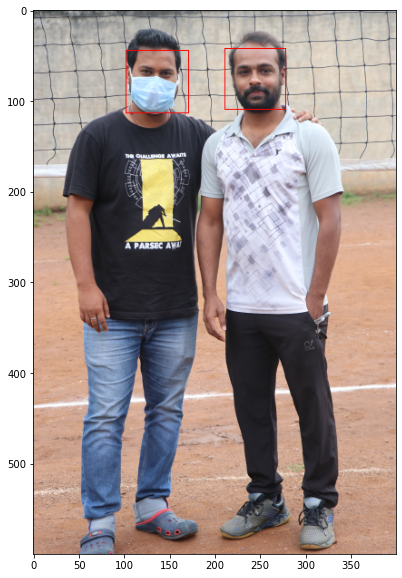

In [5]:
if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        if label[i]==1:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(255,0,0),1)
        else:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

#### Red box shows violation of social distancing.

### Using VGG19 for mask detection


In [6]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

In [7]:
#Load train and test set
train_dir = 'input/Face Mask Dataset/Train'
test_dir = 'input/Face Mask Dataset/Test'
val_dir = 'input/Face Mask Dataset/Validation'

In [8]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### Building VGG19 transfer learning model.

In [9]:
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 16386     
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [10]:
model.compile(optimizer="SGD",loss="categorical_crossentropy",metrics ="accuracy")

In [11]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_generator)//32,
                              epochs=500,validation_data=val_generator,
                              validation_steps=len(val_generator)//32)


Epoch 1/500
9/9 [==============================] - 12s 160ms/step - loss: 3.6219 - accuracy: 0.5903
Epoch 2/500
9/9 [==============================] - 2s 158ms/step - loss: 5.4030 - accuracy: 0.4965
Epoch 3/500
9/9 [==============================] - 1s 149ms/step - loss: 3.5090 - accuracy: 0.6354
Epoch 4/500
9/9 [==============================] - 2s 155ms/step - loss: 0.2492 - accuracy: 0.9062
Epoch 5/500
9/9 [==============================] - 1s 155ms/step - loss: 0.8044 - accuracy: 0.8229
Epoch 6/500
9/9 [==============================] - 1s 149ms/step - loss: 0.2449 - accuracy: 0.9132
Epoch 7/500
9/9 [==============================] - 1s 149ms/step - loss: 0.8526 - accuracy: 0.8125
Epoch 8/500
9/9 [==============================] - 1s 145ms/step - loss: 0.2562 - accuracy: 0.9201
Epoch 9/500
9/9 [==============================] - 1s 142ms/step - loss: 0.2116 - accuracy: 0.9340
Epoch 10/500
9/9 [==============================] - 1s 138ms/step - loss: 0.2216 - accuracy: 0.9236
Epoch 11

9/9 [==============================] - 1s 131ms/step - loss: 0.1184 - accuracy: 0.9444
Epoch 84/500
9/9 [==============================] - 1s 132ms/step - loss: 0.0540 - accuracy: 0.9861
Epoch 85/500
9/9 [==============================] - 1s 127ms/step - loss: 0.0823 - accuracy: 0.9688
Epoch 86/500
9/9 [==============================] - 1s 129ms/step - loss: 0.0607 - accuracy: 0.9757
Epoch 87/500
9/9 [==============================] - 1s 131ms/step - loss: 0.0809 - accuracy: 0.9792
Epoch 88/500
9/9 [==============================] - 1s 133ms/step - loss: 0.0732 - accuracy: 0.9861
Epoch 89/500
9/9 [==============================] - 1s 134ms/step - loss: 0.0716 - accuracy: 0.9861
Epoch 90/500
9/9 [==============================] - 1s 129ms/step - loss: 0.0406 - accuracy: 0.9826
Epoch 91/500
9/9 [==============================] - 1s 128ms/step - loss: 0.0709 - accuracy: 0.9688
Epoch 92/500
9/9 [==============================] - 1s 126ms/step - loss: 0.0647 - accuracy: 0.9826
Epoch 93/500


9/9 [==============================] - 1s 128ms/step - loss: 0.0363 - accuracy: 0.9896
Epoch 165/500
9/9 [==============================] - 1s 126ms/step - loss: 0.0600 - accuracy: 0.9826
Epoch 166/500
9/9 [==============================] - 1s 133ms/step - loss: 0.0552 - accuracy: 0.9722
Epoch 167/500
9/9 [==============================] - 2s 159ms/step - loss: 0.0514 - accuracy: 0.9792
Epoch 168/500
9/9 [==============================] - 1s 139ms/step - loss: 0.0403 - accuracy: 0.9861
Epoch 169/500
9/9 [==============================] - 1s 139ms/step - loss: 0.0284 - accuracy: 0.9896
Epoch 170/500
9/9 [==============================] - 1s 140ms/step - loss: 0.0337 - accuracy: 0.9896
Epoch 171/500
9/9 [==============================] - 1s 142ms/step - loss: 0.0375 - accuracy: 0.9896
Epoch 172/500
9/9 [==============================] - 1s 133ms/step - loss: 0.0599 - accuracy: 0.9757
Epoch 173/500
9/9 [==============================] - 1s 140ms/step - loss: 0.0354 - accuracy: 0.9861
Epoc

9/9 [==============================] - 1s 137ms/step - loss: 0.0427 - accuracy: 0.9896
Epoch 246/500
9/9 [==============================] - 1s 134ms/step - loss: 0.0268 - accuracy: 0.9896
Epoch 247/500
9/9 [==============================] - 1s 141ms/step - loss: 0.0427 - accuracy: 0.9757
Epoch 248/500
9/9 [==============================] - 1s 150ms/step - loss: 0.0223 - accuracy: 0.9896
Epoch 249/500
9/9 [==============================] - 1s 146ms/step - loss: 0.0294 - accuracy: 0.9896
Epoch 250/500
9/9 [==============================] - 1s 139ms/step - loss: 0.0350 - accuracy: 0.9965
Epoch 251/500
9/9 [==============================] - 1s 141ms/step - loss: 0.0689 - accuracy: 0.9757
Epoch 252/500
9/9 [==============================] - 1s 136ms/step - loss: 0.0352 - accuracy: 0.9861
Epoch 253/500
9/9 [==============================] - 1s 140ms/step - loss: 0.0200 - accuracy: 0.9931
Epoch 254/500
9/9 [==============================] - 1s 137ms/step - loss: 0.0291 - accuracy: 0.9896
Epoc

9/9 [==============================] - 1s 138ms/step - loss: 0.0267 - accuracy: 0.9896
Epoch 327/500
9/9 [==============================] - 1s 134ms/step - loss: 0.0212 - accuracy: 0.9896
Epoch 328/500
9/9 [==============================] - 1s 146ms/step - loss: 0.0281 - accuracy: 0.9896
Epoch 329/500
9/9 [==============================] - 1s 135ms/step - loss: 0.0194 - accuracy: 0.9965
Epoch 330/500
9/9 [==============================] - 1s 138ms/step - loss: 0.0238 - accuracy: 0.9931
Epoch 331/500
9/9 [==============================] - 1s 141ms/step - loss: 0.0362 - accuracy: 0.9931
Epoch 332/500
9/9 [==============================] - 1s 143ms/step - loss: 0.0124 - accuracy: 0.9965
Epoch 333/500
9/9 [==============================] - 1s 142ms/step - loss: 0.0374 - accuracy: 0.9826
Epoch 334/500
9/9 [==============================] - 1s 140ms/step - loss: 0.0122 - accuracy: 0.9965
Epoch 335/500
9/9 [==============================] - 1s 142ms/step - loss: 0.0511 - accuracy: 0.9826
Epoc

9/9 [==============================] - 1s 128ms/step - loss: 0.0333 - accuracy: 0.9896
Epoch 408/500
9/9 [==============================] - 1s 133ms/step - loss: 0.0291 - accuracy: 0.9861
Epoch 409/500
9/9 [==============================] - 1s 137ms/step - loss: 0.0507 - accuracy: 0.9861
Epoch 410/500
9/9 [==============================] - 1s 134ms/step - loss: 0.0581 - accuracy: 0.9757
Epoch 411/500
9/9 [==============================] - 1s 130ms/step - loss: 0.0596 - accuracy: 0.9826
Epoch 412/500
9/9 [==============================] - 1s 139ms/step - loss: 0.0378 - accuracy: 0.9896
Epoch 413/500
9/9 [==============================] - 1s 135ms/step - loss: 0.0144 - accuracy: 1.0000
Epoch 414/500
9/9 [==============================] - 1s 135ms/step - loss: 0.0244 - accuracy: 0.9896
Epoch 415/500
9/9 [==============================] - 1s 136ms/step - loss: 0.0207 - accuracy: 0.9896
Epoch 416/500
9/9 [==============================] - 1s 131ms/step - loss: 0.0219 - accuracy: 0.9896
Epoc

9/9 [==============================] - 1s 129ms/step - loss: 0.0358 - accuracy: 0.9792
Epoch 489/500
9/9 [==============================] - 1s 128ms/step - loss: 0.0277 - accuracy: 0.9931
Epoch 490/500
9/9 [==============================] - 1s 126ms/step - loss: 0.0415 - accuracy: 0.9826
Epoch 491/500
9/9 [==============================] - 1s 126ms/step - loss: 0.0342 - accuracy: 0.9861
Epoch 492/500
9/9 [==============================] - 1s 138ms/step - loss: 0.0535 - accuracy: 0.9896
Epoch 493/500
9/9 [==============================] - 1s 127ms/step - loss: 0.0321 - accuracy: 0.9861
Epoch 494/500
9/9 [==============================] - 1s 131ms/step - loss: 0.0136 - accuracy: 0.9965
Epoch 495/500
9/9 [==============================] - 1s 125ms/step - loss: 0.0327 - accuracy: 0.9861
Epoch 496/500
9/9 [==============================] - 1s 129ms/step - loss: 0.0709 - accuracy: 0.9653
Epoch 497/500
9/9 [==============================] - 1s 130ms/step - loss: 0.0285 - accuracy: 0.9931
Epoc

In [12]:
model.evaluate_generator(test_generator)

[0.027407243847846985, 0.9912499785423279]

In [13]:
model.evaluate_generator(val_generator)

[0.02571476437151432, 0.9925000071525574]

In [14]:
history_1 = model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_generator)//32,
                              epochs=500,validation_data=test_generator,
                              validation_steps=len(test_generator)//32)

Epoch 1/500
9/9 [==============================] - 1s 147ms/step - loss: 0.0212 - accuracy: 0.9896
Epoch 2/500
9/9 [==============================] - 1s 131ms/step - loss: 0.0171 - accuracy: 0.9965
Epoch 3/500
9/9 [==============================] - 1s 129ms/step - loss: 0.0368 - accuracy: 0.9931
Epoch 4/500
9/9 [==============================] - 1s 126ms/step - loss: 0.0274 - accuracy: 0.9931
Epoch 5/500
9/9 [==============================] - 1s 131ms/step - loss: 0.0580 - accuracy: 0.9792
Epoch 6/500
9/9 [==============================] - 1s 125ms/step - loss: 0.0224 - accuracy: 0.9931
Epoch 7/500
9/9 [==============================] - 1s 127ms/step - loss: 0.0254 - accuracy: 0.9896
Epoch 8/500
9/9 [==============================] - 1s 131ms/step - loss: 0.0130 - accuracy: 0.9965
Epoch 9/500
9/9 [==============================] - 1s 129ms/step - loss: 0.0166 - accuracy: 0.9965
Epoch 10/500
9/9 [==============================] - 1s 126ms/step - loss: 0.0231 - accuracy: 0.9896
Epoch 11/

9/9 [==============================] - 1s 129ms/step - loss: 0.0144 - accuracy: 0.9965
Epoch 84/500
9/9 [==============================] - 1s 128ms/step - loss: 0.0176 - accuracy: 0.9965
Epoch 85/500
9/9 [==============================] - 1s 129ms/step - loss: 0.0420 - accuracy: 0.9826
Epoch 86/500
9/9 [==============================] - 1s 130ms/step - loss: 0.0263 - accuracy: 0.9896
Epoch 87/500
9/9 [==============================] - 1s 130ms/step - loss: 0.0372 - accuracy: 0.9826
Epoch 88/500
9/9 [==============================] - 1s 134ms/step - loss: 0.0373 - accuracy: 0.9861
Epoch 89/500
9/9 [==============================] - 1s 137ms/step - loss: 0.0188 - accuracy: 0.9965
Epoch 90/500
9/9 [==============================] - 1s 135ms/step - loss: 0.0171 - accuracy: 0.9965
Epoch 91/500
9/9 [==============================] - 1s 133ms/step - loss: 0.0165 - accuracy: 0.9965
Epoch 92/500
9/9 [==============================] - 1s 136ms/step - loss: 0.0216 - accuracy: 0.9965
Epoch 93/500


9/9 [==============================] - 1s 133ms/step - loss: 0.0182 - accuracy: 0.9896
Epoch 165/500
9/9 [==============================] - 1s 135ms/step - loss: 0.0229 - accuracy: 0.9965
Epoch 166/500
9/9 [==============================] - 1s 132ms/step - loss: 0.0145 - accuracy: 0.9965
Epoch 167/500
9/9 [==============================] - 1s 133ms/step - loss: 0.0310 - accuracy: 0.9931
Epoch 168/500
9/9 [==============================] - 1s 134ms/step - loss: 0.0466 - accuracy: 0.9826
Epoch 169/500
9/9 [==============================] - 1s 135ms/step - loss: 0.0154 - accuracy: 0.9963
Epoch 170/500
9/9 [==============================] - 1s 129ms/step - loss: 0.0107 - accuracy: 0.9965
Epoch 171/500
9/9 [==============================] - 1s 129ms/step - loss: 0.0300 - accuracy: 0.9896
Epoch 172/500
9/9 [==============================] - 1s 133ms/step - loss: 0.0116 - accuracy: 0.9965
Epoch 173/500
9/9 [==============================] - 1s 135ms/step - loss: 0.0296 - accuracy: 0.9896
Epoc

9/9 [==============================] - 1s 126ms/step - loss: 0.0176 - accuracy: 0.9965
Epoch 246/500
9/9 [==============================] - 1s 128ms/step - loss: 0.0419 - accuracy: 0.9861
Epoch 247/500
9/9 [==============================] - 1s 131ms/step - loss: 0.0142 - accuracy: 0.9965
Epoch 248/500
9/9 [==============================] - 1s 136ms/step - loss: 0.0235 - accuracy: 0.9931
Epoch 249/500
9/9 [==============================] - 1s 126ms/step - loss: 0.0159 - accuracy: 0.9963
Epoch 250/500
9/9 [==============================] - 1s 130ms/step - loss: 0.0181 - accuracy: 0.9896
Epoch 251/500
9/9 [==============================] - 1s 131ms/step - loss: 0.0620 - accuracy: 0.9757
Epoch 252/500
9/9 [==============================] - 1s 139ms/step - loss: 0.0157 - accuracy: 0.9965
Epoch 253/500
9/9 [==============================] - 1s 130ms/step - loss: 0.0177 - accuracy: 0.9926
Epoch 254/500
9/9 [==============================] - 1s 134ms/step - loss: 0.0390 - accuracy: 0.9826
Epoc

9/9 [==============================] - 1s 126ms/step - loss: 0.0244 - accuracy: 0.9931
Epoch 327/500
9/9 [==============================] - 1s 129ms/step - loss: 0.0181 - accuracy: 0.9965
Epoch 328/500
9/9 [==============================] - 1s 132ms/step - loss: 0.0221 - accuracy: 0.9965
Epoch 329/500
9/9 [==============================] - 1s 130ms/step - loss: 0.0146 - accuracy: 0.9965
Epoch 330/500
9/9 [==============================] - 1s 125ms/step - loss: 0.0076 - accuracy: 1.0000
Epoch 331/500
9/9 [==============================] - 1s 126ms/step - loss: 0.0307 - accuracy: 0.9931
Epoch 332/500
9/9 [==============================] - 1s 129ms/step - loss: 0.0224 - accuracy: 0.9861
Epoch 333/500
9/9 [==============================] - 1s 131ms/step - loss: 0.0165 - accuracy: 0.9896
Epoch 334/500
9/9 [==============================] - 1s 128ms/step - loss: 0.0140 - accuracy: 0.9965
Epoch 335/500
9/9 [==============================] - 1s 127ms/step - loss: 0.0366 - accuracy: 0.9861
Epoc

9/9 [==============================] - 1s 126ms/step - loss: 0.0372 - accuracy: 0.9896
Epoch 408/500
9/9 [==============================] - 1s 127ms/step - loss: 0.0299 - accuracy: 0.9861
Epoch 409/500
9/9 [==============================] - 1s 132ms/step - loss: 0.0282 - accuracy: 0.9931
Epoch 410/500
9/9 [==============================] - 1s 126ms/step - loss: 0.0274 - accuracy: 0.9861
Epoch 411/500
9/9 [==============================] - 1s 127ms/step - loss: 0.0060 - accuracy: 1.0000
Epoch 412/500
9/9 [==============================] - 1s 127ms/step - loss: 0.0237 - accuracy: 0.9896
Epoch 413/500
9/9 [==============================] - 1s 129ms/step - loss: 0.0117 - accuracy: 0.9965
Epoch 414/500
9/9 [==============================] - 1s 124ms/step - loss: 0.0132 - accuracy: 1.0000
Epoch 415/500
9/9 [==============================] - 1s 130ms/step - loss: 0.0302 - accuracy: 0.9896
Epoch 416/500
9/9 [==============================] - 1s 125ms/step - loss: 0.0174 - accuracy: 0.9965
Epoc

9/9 [==============================] - 1s 129ms/step - loss: 0.0156 - accuracy: 0.9965
Epoch 489/500
9/9 [==============================] - 1s 126ms/step - loss: 0.0353 - accuracy: 0.9826
Epoch 490/500
9/9 [==============================] - 1s 127ms/step - loss: 0.0254 - accuracy: 0.9896
Epoch 491/500
9/9 [==============================] - 1s 128ms/step - loss: 0.0185 - accuracy: 0.9965
Epoch 492/500
9/9 [==============================] - 1s 126ms/step - loss: 0.0060 - accuracy: 1.0000
Epoch 493/500
9/9 [==============================] - 1s 134ms/step - loss: 0.0282 - accuracy: 0.9861
Epoch 494/500
9/9 [==============================] - 1s 131ms/step - loss: 0.0146 - accuracy: 0.9965
Epoch 495/500
9/9 [==============================] - 1s 130ms/step - loss: 0.0337 - accuracy: 0.9861
Epoch 496/500
9/9 [==============================] - 1s 132ms/step - loss: 0.0270 - accuracy: 0.9896
Epoch 497/500
9/9 [==============================] - 1s 130ms/step - loss: 0.0169 - accuracy: 0.9965
Epoc

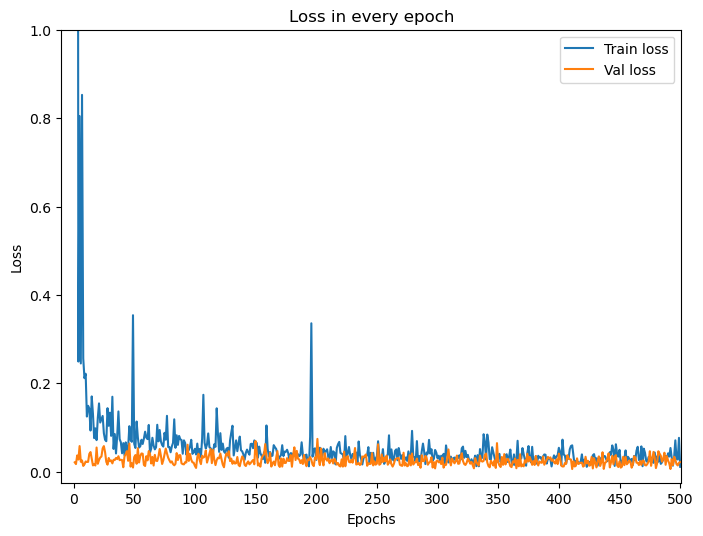

In [15]:
fig = plt.figure(figsize=(8, 6), dpi=100)
#fig = plt.figure()
ax = fig.add_subplot(111)

x = range(1,501)

ax.plot(x,history.history['loss'], label= 'Train loss')
ax.plot(x,history_1.history['loss'], label='Val loss')
ax.legend()

plt.ylim(-0.025, 1)
plt.xlim(-10, 501)
plt.xticks(np.arange(0,501, 50))

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss in every epoch')
plt.show()

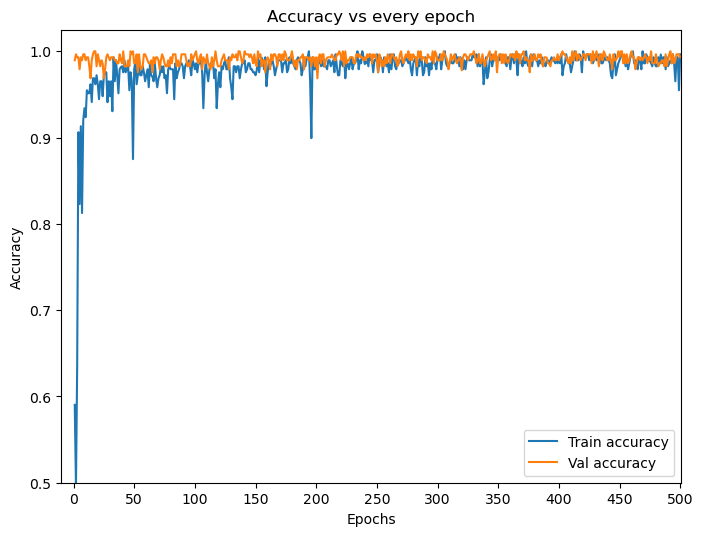

In [16]:
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(111)

x = range(1,501)

ax.plot(x,history.history['accuracy'], label= 'Train accuracy')
ax.plot(x,history_1.history['accuracy'], label='Val accuracy')
ax.legend()

plt.ylim(0.5, 1.025)
plt.xlim(-10, 501)
plt.xticks(np.arange(0,501, 50))

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs every epoch')
plt.show()

### Testing the model on the test data

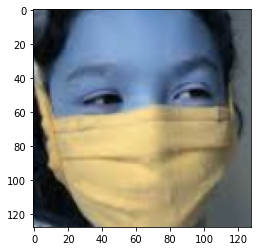

In [17]:
sample_mask_img = cv2.imread('input/Face Mask Dataset/Test/WithMask/1565.png')
sample_mask_img = cv2.resize(sample_mask_img,(128,128))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,128,128,3])
sample_mask_img = sample_mask_img/255.0

In [18]:
var1 = model.predict(sample_mask_img)
var = var1.tolist() 
print('Accuracy for person with mask:',(var[0][0])*100) 
print('Accuracy for person without mask:',(var[0][1])*100)

Accuracy for person with mask: 99.73080158233643
Accuracy for person without mask: 0.5596385803073645


The model is able to classify if the person is wearing a mask or not.

### Save the model.

In [19]:
model.save('masknet.h5')

### Integrating with haar cascade

We now take crops of the faces detected in the image and use the model trained in the above section to determine whether the individual faces have a mask or not.

In [20]:
mask_label = {0:'MASK',1:'NO MASK'}
dist_label = {0:(0,255,0),1:(255,0,0)}

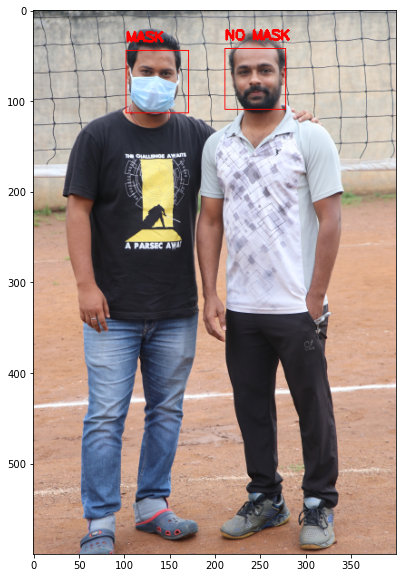

In [21]:
if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

#### Red boxes shows violation of social distancing.

## Results

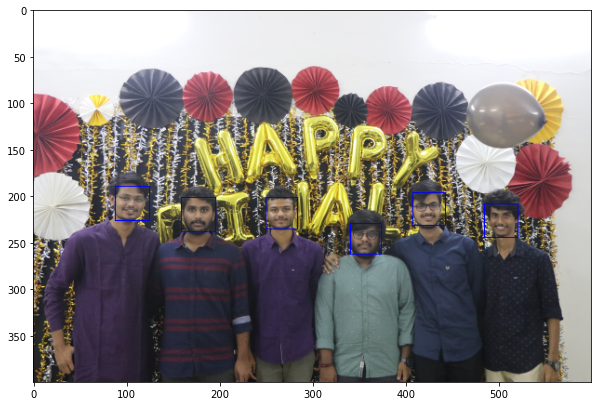

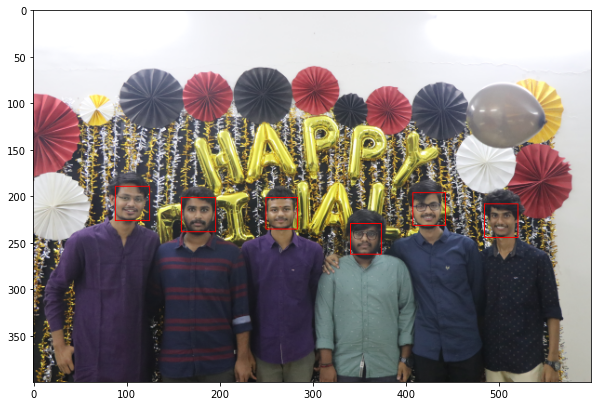

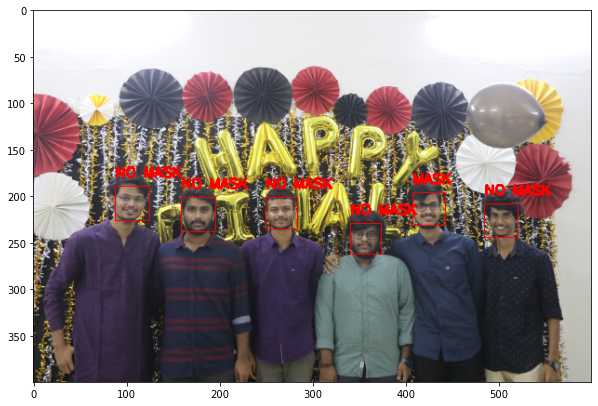

In [22]:
img = cv2.imread('input/IMG_8520.JPG')

scale_percent = 10 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)

img = cv2.resize(img,dim,interpolation = cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=2) #returns a list of (x,y,w,h) tuples
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(10,10))
plt.imshow(out_img)

if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        if label[i]==1:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(255,0,0),1)
        else:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

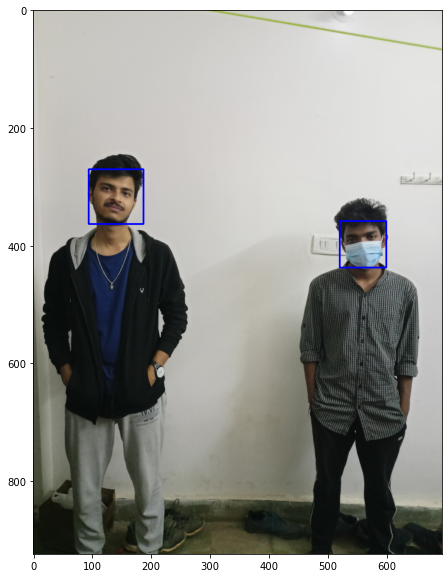

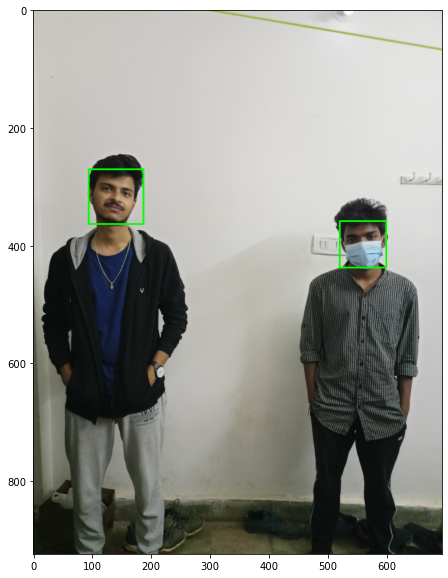

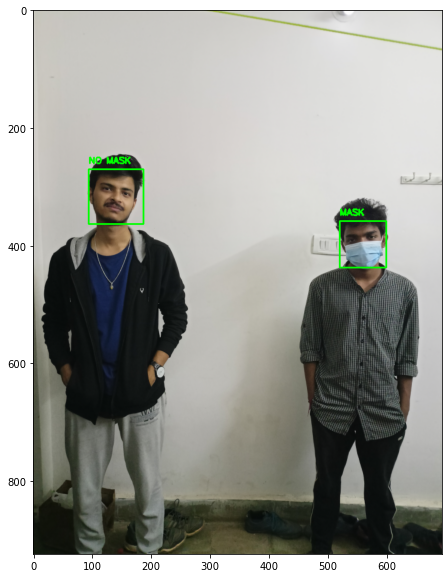

In [23]:
img = cv2.imread('input/sd8.jpg')

scale_percent = 10 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
img = cv2.resize(img,dim,interpolation = cv2.INTER_AREA)

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=3) #returns a list of (x,y,w,h) tuples
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),2)
plt.figure(figsize=(10,10))
plt.imshow(out_img)

if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        if label[i]==1:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(255,0,0),2)
        else:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),2)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],2)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")